# Metropolis Hastings
Accomadating notebook to reproduce the experiments from the Bachelor's Thesis 'The Metropolis-Hastings algorithm for large datasets'

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import time
import multiprocessing as mp

## Useful functions

In [2]:

#This function implements the subsampling methods used for the samples produced by MH
def create_sample(data, b, c):
    # Discard the first b of elements
    data = data[b:]

    # Select every c datapoint
    data = data[::c]

    return data

# Function to clean up acceptance probabilties
# Replace values bigger than 1 with 1
def clean_acceptance_probability(array):
    array = np.where(array > 1, 1, array)
    return array


In [3]:
import numpy as np
#This cell implements all plotting functions
def plt_samples(dataset):
    '''Plots the samples in a jointplot'''
    # Create a jointplot with fading datapoints
    sns.jointplot(x=dataset[:, 0], y=dataset[:, 1], kind='hex', cmap='Blues', alpha=1)

    # Show the plot
    plt.show()

def plot_running_average(data, w):
    '''Plots the running average of a given array over a window of w iterations'''
    running_avg = np.convolve(data, np.ones(w), 'valid') / w
    plt.plot(running_avg)
    plt.xlabel('Iteration')
    plt.ylabel('Running Average ')
    plt.title('Running Average over a Window of {} Data Points'.format(w))
    plt.show()

def plot_acceptance_rate(array):
    plt.plot(array)
    plt.xlabel('Iteration')
    plt.ylabel('Acceptance Probability')
    plt.title('Acceptance Probability')
    plt.show()



In [4]:
#
def sample_quality_score(sample, true_theta):
    '''Computes the quality score of a sample given the true theta'''
    # Compute the mean of the sample

    sample_mean = np.mean(sample, axis=0)
    mean_score = npl.norm(sample_mean - true_theta)

    sample_variance = np.std(sample)


    return mean_score, sample_variance

In [5]:
#This cell implements all likelihood functions and their gradients for the different statistical models
class Normal_param_loglkhd():
    def __init__(self) -> None:
        pass

    def comp_func(self,data, theta):
        '''Return log_likelihood of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        log_lkhd = -((data - mu) ** 2) / (2 * sigma**2) - np.log(sigma)
        return log_lkhd

    def comp_grad(self,data, theta):
        '''Return gradient of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        grad_mu = (data - mu) / sigma**2
        grad_sigma = ((data - mu) ** 2 - sigma**2) / sigma**3
        return grad_mu, grad_sigma

    def comp_hess(self, data, theta):
        '''Return hessian of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        hess_mu_mu = -1/sigma**2
        hess_mu_sig = (-2)*(data - mu)/sigma**3
        hess_sig_sig = (-3)*((data - mu) ** 2) / sigma**4 + 1/sigma**2
        return hess_mu_mu, hess_mu_sig, hess_mu_sig, hess_sig_sig

    def comp_third_deriv(data, theta):
        mu = theta[0]
        sigma = theta[0]
        td_mu_mu_mu = 0
        td_mu_mu_sig = 2/sigma**3
        td_mu_sig_sig = (6)*(data - mu)/sigma**4
        td_sig_sig_sig = (12)*((data - mu) ** 2) / sigma**5 - 2/sigma**3
        return  td_mu_mu_mu, td_mu_mu_sig, td_mu_sig_sig, td_sig_sig_sig

    def comp_log_bounding_func(self, data, subsample, theta, thetaMAP, proposal, lkhd_MAP, grad_MAP, hess_MAP):
        h = theta - thetaMAP
        grad = np.dot(grad_MAP.T)
        hess = np.dot(np.dot(hess_MAP.T, h), h)
        #Compute min and max of data
        min_data = np.min(data)
        max_data = np.max(data)
        xMinusMuMax = np.max(np.abs([1, min_data - theta[0],max_data - theta[0], min_data - thetaMAP[0], max_data - thetaMAP[0], max_data - proposal[0], min_data - proposal[0]]))
        sigmaMin = np.min(theta[1], thetaMAP[1], proposal[1])
        M = np.max(np.abs(self.comp_third_deriv(xMinusMuMax, np.array([0,sigmaMin]))))
        R = M/6*np.abs(h)**2
        b = lkhd_MAP + grad + hess + R
        return b

class Bimodal_norm_param_loglkhd():

    def comp_func(self, data, theta):
            '''Return log_likelihood of mu1 (expected value of the first normal distribution), mu2 (expected value of the second normal distribution) and p (probability of the first normal distribution) of a bimodal normal distribution for given data'''
            mu_1 = theta[0]
            mu_2 = theta[1]
            p = 0.5
            lkhd_mu1 = np.exp((-((data - mu_1) ** 2)) / 2)
            lkhd_mu2 = np.exp((-((data - mu_2) ** 2)) / 2)
            log_lkhd = np.log(p * lkhd_mu1 + (1 - p) * lkhd_mu2)
            return log_lkhd

    def comp_grad(self, data, theta):
        mu_1 = theta[0]
        mu_2 = theta[1]
        p = 0.5
        denominator = (p * np.exp(-((data - mu_1) ** 2) / 2) + (1 - p) * np.exp(-((data - mu_2) ** 2) / 2))
        grad_mu1 = p*(data - mu_1)*np.exp(-((data - mu_1) ** 2) / 2) / denominator
        grad_mu2 = (1-p)*(data - mu_2)*np.exp(-((data - mu_2) ** 2) / 2) / denominator
        return grad_mu1, grad_mu2

    def comp_hess(self, data, theta):
        pass

#Test the likelihood function
#test_norm = Normal_param_loglkhd()
#data = np.array([1, 2, 3, 4, 5])
#print(test_norm.comp_func(data, np.array([0,1])))


In [6]:
# This cell implements all proposal functions

class Gaussian_Random_Walk():
    def propose_sample(self, theta, stepsize):
        '''Propose a new sample using a Gaussian random walk proposal'''
        proposal = npr.normal(theta, stepsize, len(theta))
        return proposal

class Langevin_Sampler():
    def propose_sample(self, theta, stepsize, grad, gradient_scaler):
        '''Propose a new sample using a Langevin proposal'''
        proposal = npr.normal(theta + grad * gradient_scaler, stepsize, len(theta)) #TODO: Check if this is correct
        return proposal
    # Test samplers
#test_sampler = Gaussian_Random_Walk()
#print(test_sampler.propose_sample(np.array([0, 0]), 0.1))

## Running Examples

[-2.25211836  0.60568705  1.18338458 ...  1.83363722  1.00373374
  1.77219844]


(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 4.000e+00, 5.000e+00, 1.600e+01, 1.000e+01,
        2.000e+01, 3.200e+01, 4.200e+01, 4.100e+01, 6.800e+01, 7.400e+01,
        1.070e+02, 1.190e+02, 1.650e+02, 2.080e+02, 2.570e+02, 3.040e+02,
        3.810e+02, 4.630e+02, 5.480e+02, 6.470e+02, 7.170e+02, 8.900e+02,
        9.520e+02, 1.140e+03, 1.282e+03, 1.419e+03, 1.623e+03, 1.790e+03,
        1.933e+03, 2.122e+03, 2.283e+03, 2.476e+03, 2.591e+03, 2.665e+03,
        2.949e+03, 3.069e+03, 3.056e+03, 3.232e+03, 3.300e+03, 3.293e+03,
        3.393e+03, 3.381e+03, 3.225e+03, 3.389e+03, 3.314e+03, 3.140e+03,
        2.981e+03, 2.869e+03, 2.762e+03, 2.682e+03, 2.473e+03, 2.289e+03,
        2.088e+03, 1.964e+03, 1.839e+03, 1.620e+03, 1.425e+03, 1.296e+03,
        1.218e+03, 1.062e+03, 8.500e+02, 7.120e+02, 6.570e+02, 5.730e+02,
        4.460e+02, 4.190e+02, 3.000e+02, 2.930e+02, 2.320e+02, 1.870e+02,
        1.450e+02, 1.100e+02, 8.000e+0

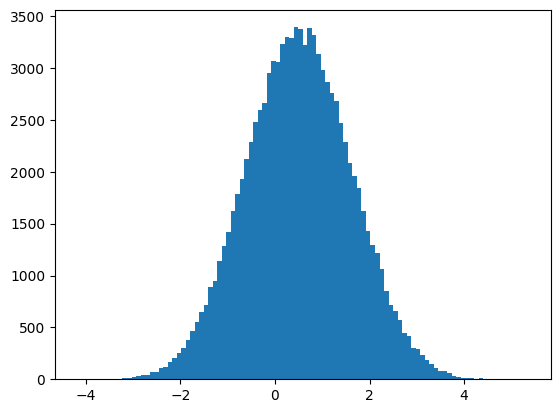

In [7]:
npr.seed(1)
N = 10**5 # Number of data points

# Norm param dataset
normal_param_data = npr.normal(0, 1, N)
realMean = np.mean(normal_param_data)
realStd = np.std(normal_param_data)
normal_param_MAP = np.array([realMean, realStd])
#plt.hist(normal_param_data, bins=100)

# Bimodal norm param dataset
p =1/2
mu1 = 0
mu2 = 1
mu1_normal = npr.normal(mu1, 1, int(N*(p)))
mu2_normal = npr.normal(mu2, 1, int(N*(1-p)))
bimodal_data = np.concatenate((mu1_normal, mu2_normal))
print(bimodal_data)
npr.shuffle(bimodal_data)
plt.hist(bimodal_data, bins=100)


# Basic Alorithms

## vanillaMH

In [8]:
def vanillaMH(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    samples[0] = initial_theta
    lkhd = np.empty(num_iterations)
    lkhd[0] = np.sum(lkhd_function.comp_func(data, initial_theta))

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = proposal_function.propose_sample(samples[i], stepsize)

        # Compute the acceptance probability
        lkhd_proposal = np.sum(lkhd_function.comp_func(data, proposal))
        acceptence_prob[i] = np.exp(lkhd_proposal - lkhd[i])

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd

In [9]:
# vanillaMH
# Parameters
data = bimodal_data
lkhd = Bimodal_norm_param_loglkhd()
proposal = Gaussian_Random_Walk()
initial_theta = np.array([1,1])
num_iterations = 10**3
stepsize = 1

samples, accepted, acceptence_prob, lkhd = vanillaMH(data, lkhd, proposal, initial_theta, num_iterations, stepsize)
print("SUCCESFULLY RAN vanillaMH")

/tmp/ipykernel_5313/3917280845.py:17: RuntimeWarning: overflow encountered in exp
  acceptence_prob[i] = np.exp(lkhd_proposal - lkhd[i])


SUCCESFULLY RAN vanillaMH


(7.033413402893845, 0.46661026014235957)


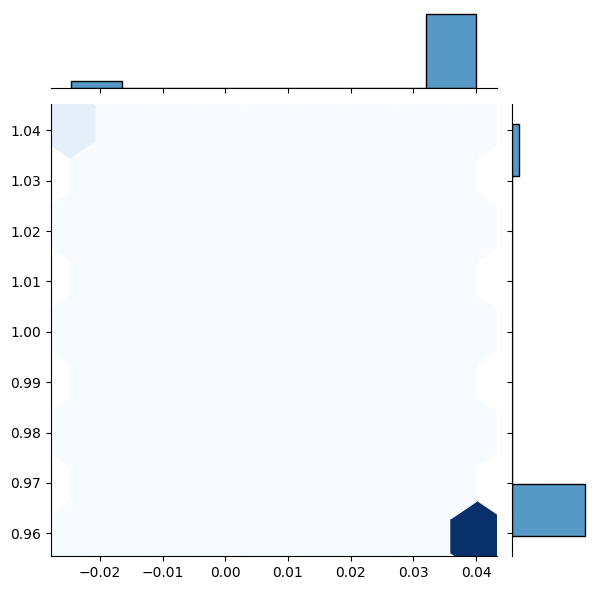

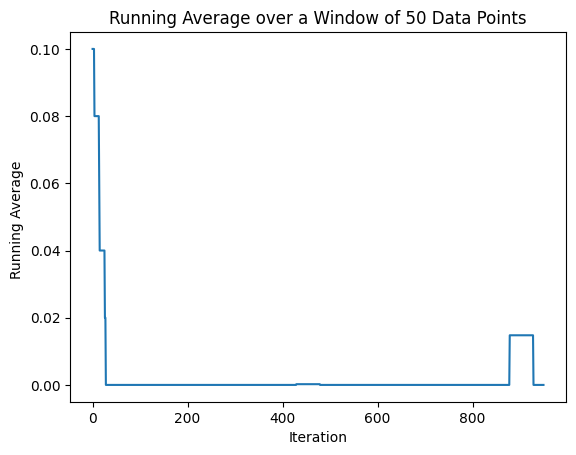

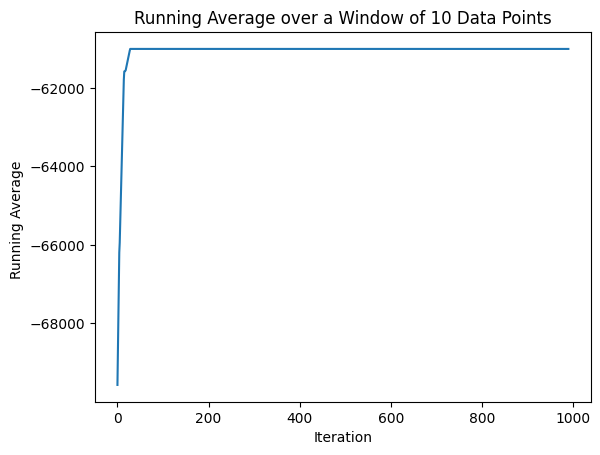

In [10]:
plot_samples = create_sample(samples, 200,10)
print(sample_quality_score(plot_samples, np.array([0,8])
                           ))

plt_samples(plot_samples)
acceptence_prob = clean_acceptance_probability(acceptence_prob)
plot_running_average(acceptence_prob, 50)
plot_running_average(lkhd, 10)

## MALA

In [11]:
def mala(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, gradient_scaler, lkhd_scaler):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    lkhd = np.empty(num_iterations)
    grad = np.empty((num_iterations, initial_theta.size))
    #Compute initial values
    samples[0] = initial_theta
    lkhd[0] = np.mean(lkhd_function.comp_func(data, initial_theta))
    grad[0] = np.mean(lkhd_function.comp_grad(data, initial_theta))

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = proposal_function.propose_sample(samples[i], stepsize, grad[i], gradient_scaler)

        # Compute the acceptance probability
        lkhd_proposal = np.mean(lkhd_function.comp_func(data, proposal))
        grad_proposal = np.mean(lkhd_function.comp_grad(data, proposal))
        diff_old = npl.norm(proposal - samples[i] - gradient_scaler*grad[i])**2
        diff_new = npl.norm(samples[i] - proposal - gradient_scaler*grad_proposal)**2
        lkhd_diff = (lkhd_proposal - lkhd[i])*lkhd_scaler
        acceptence_prob[i] = np.exp(lkhd_diff + (diff_old - diff_new) / (2*stepsize))

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            grad[i+1] = grad_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            grad[i+1] = grad[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd


In [12]:
# MALA
# Parameters
data = bimodal_data
lkhd = Bimodal_norm_param_loglkhd()
proposal = Langevin_Sampler()
initial_theta = np.array([2,2])
num_iterations = 10**3
stepsize = 0.1
gradient_scaler = 1
lkhd_scaler = data.size*0.001

samples, accepted, acceptence_prob, lkhd = mala(data, lkhd, proposal, initial_theta, num_iterations, stepsize, gradient_scaler, lkhd_scaler)
print("SUCCESFULLY RAN MALA")

SUCCESFULLY RAN MALA


(2.060406576940692, 0.47560697252500833)


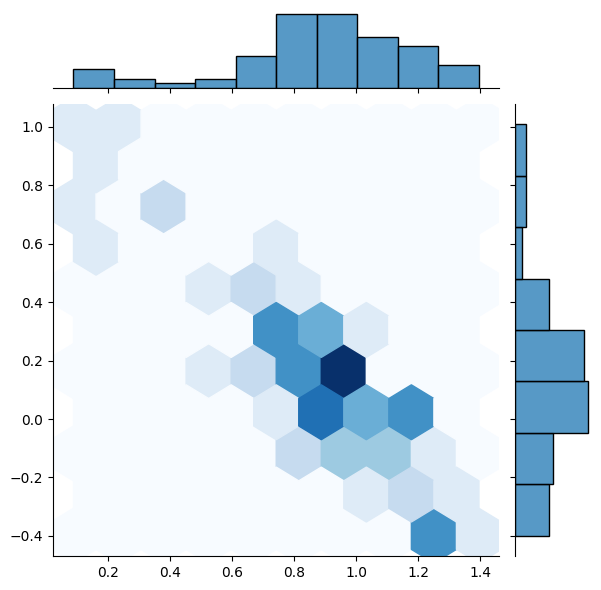

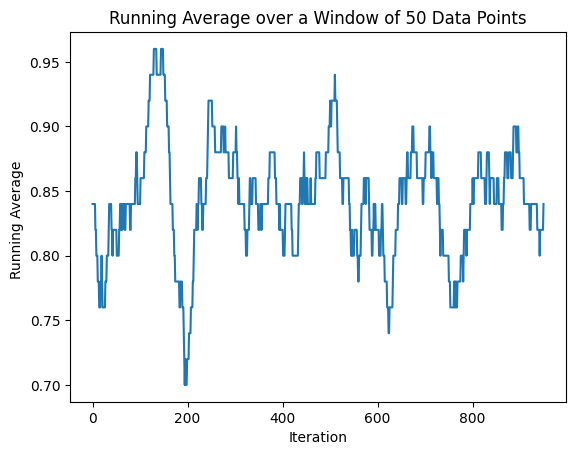

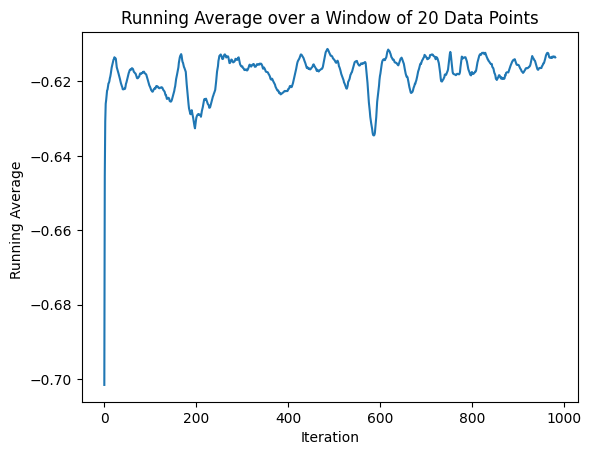

In [13]:
plot_samples = create_sample(samples, 200,11)
print(sample_quality_score(plot_samples, np.array([0,2])))

plt_samples(plot_samples)
plot_running_average(accepted, 50)
plot_running_average(lkhd, 20)

# Scalable Adaptations

## consensusMC

In [14]:
#Useful functions for consensusMC
def batch_divider(data, num_batches):
    '''Divide the data into random batches'''
    batch_size = data.size // num_batches  # Calculate batch size
    indices = npr.permutation(data.size) # Create shuffled indices
    batches = [indices[i*batch_size:(i+1)*batch_size] for i in range(num_batches)] # Split shuffled indices into batches
    batches_data = [data[batch] for batch in batches] # Extract batches from batches using shuffled indices
    return batches_data

#Test
#data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#test = batch_divider(data, 3)
#print(test)

def batch_combiner(batch_sample_list):
    '''Combine the samples from the batches'''
    variance_list = [np.var(batch_sample) for batch_sample in batch_sample_list]
    sum_variances = np.sum(variance_list)
    weights = [variance / sum_variances for variance in variance_list]
    combined_samples = np.sum([weights[i] * batch_sample_list[i] for i in range(len(batch_sample_list))], axis=0)
    return combined_samples

#Test
batch1 = np.array([[1, 2], [3, 4], [5,6]])
batch2 = np.array([[6, 7], [8, 9], [10,11]])
batch_sample_list = [batch1, batch2, batch2]
test = batch_combiner(batch_sample_list)
print(test)



[[4.33333333 5.33333333]
 [6.33333333 7.33333333]
 [8.33333333 9.33333333]]


In [15]:
def consensusMC(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, num_batches):
    batches = batch_divider(data, num_batches)
    args = [(batch, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize) for batch in batches] # List of arguments to run MH in parallel

    batch_sample_list = []
    for i in range(num_batches): # Parallel enviorenment
        #TODO: Make it parallel, save other returns from vanillaMH
        batch_sample_list.append(vanillaMH(*args[i])[0]) # Run MH

    sample = batch_combiner(batch_sample_list) # Combine samples returned by batches
    return sample

In [16]:
# consensusMC
# Parameters
data = bimodal_data
lkhd = Bimodal_norm_param_loglkhd()
proposal = Gaussian_Random_Walk()
initial_theta = np.array([1,1])
num_iterations = 10**4
stepsize = 1
num_batches = 4

samples = consensusMC(data, lkhd, proposal, initial_theta, num_iterations, stepsize, num_batches)
print("SUCCESFULLY RAN consensusMC")

/tmp/ipykernel_5313/3917280845.py:17: RuntimeWarning: overflow encountered in exp
  acceptence_prob[i] = np.exp(lkhd_proposal - lkhd[i])


SUCCESFULLY RAN consensusMC


(0.49819000681708814, 0.210265426713858)


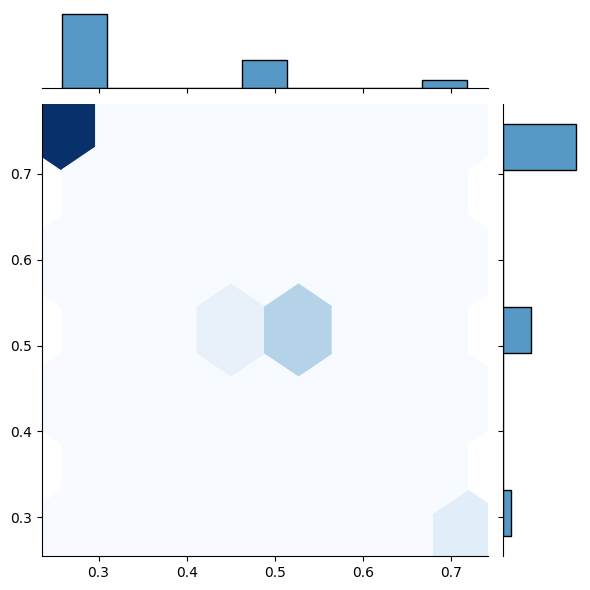

In [17]:
plot_samples = create_sample(samples, 2000,50)
print(sample_quality_score(plot_samples, np.array([0,1])))

plt_samples(plot_samples)


## csMALA

In [18]:
#Useful functions csMALA

def bernoulli_sampling(data, sampling_perc):
    '''
    Subset dataset
    '''
    subsample_indx = npr.binomial(n=1,p=sampling_perc, size=data.size)
    subsample = data[subsample_indx == 1]
    return subsample

#Test
#array = np.arange(10000)
#test = bernoulli_sampling(array, 0.5)
#print(test)
#print(test.size)

In [19]:
def csMALA(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, gradient_scaler, subsampling_perc, correction_scaler, lkhd_scaler):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    lkhd_diff = np.empty(num_iterations- 1)
    lkhd = np.empty(num_iterations)
    grad = np.empty((num_iterations, initial_theta.size))
    correction_term = np.empty(num_iterations)
    log_subsampling_perc = np.log(subsampling_perc)
    #Compute initial values
    subsample = bernoulli_sampling(data, subsampling_perc)
    correction_term[0] = correction_scaler*log_subsampling_perc*len(subsample)*lkhd_scaler**(-1)
    samples[0] = initial_theta
    lkhd[0] = np.mean(lkhd_function.comp_func(subsample, initial_theta))
    grad[0] = np.mean(lkhd_function.comp_grad(subsample, initial_theta))

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = proposal_function.propose_sample(samples[i], stepsize, grad[i], gradient_scaler)
        #New subsample
        subsample = bernoulli_sampling(data, subsampling_perc)
        # Compute the acceptance probability
        correction_term_proposal = correction_scaler*log_subsampling_perc*len(subsample)*lkhd_scaler**(-1)
        lkhd_proposal = np.mean(lkhd_function.comp_func(subsample, proposal))
        grad_proposal = np.mean(lkhd_function.comp_grad(subsample, proposal))
        diff_old = npl.norm(proposal - samples[i] - gradient_scaler*grad[i])**2
        diff_new = npl.norm(samples[i] - proposal - gradient_scaler*grad_proposal)**2
        lkhd_diff[i] = (lkhd_proposal - lkhd[i])*lkhd_scaler
        corr_diff = correction_term_proposal - correction_term[i]
        acceptence_prob[i] = np.exp(lkhd_diff[i] + corr_diff + (diff_old - diff_new) / (2*stepsize))

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            grad[i+1] = grad_proposal
            correction_term[i+1] = correction_term_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            grad[i+1] = grad[i]
            correction_term[i+1] = correction_term[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd, lkhd_diff, correction_term

In [20]:
# csMALA
# Parameters
data = bimodal_data
lkhd = Bimodal_norm_param_loglkhd()
proposal = Langevin_Sampler()
initial_theta = np.array([1,1])
num_iterations = 10**4
stepsize = 1
gradient_scaler = 1
subsampling_perc = 0.1
correction_scaler = 0.1
lkhd_scaler = data.size*(1/subsampling_perc)*0.001

samples, accepted, acceptence_prob, lkhd, lkhd_diff, correction_term = csMALA(data, lkhd, proposal, initial_theta, num_iterations, stepsize, gradient_scaler, subsampling_perc, correction_scaler,lkhd_scaler)
print("SUCCESFULLY RAN csMALA")

SUCCESFULLY RAN csMALA


-0.5944250737855576
-2.2947563036778655
1.9855256220363542e-75
(7.928648547234042, 0.48053660179335284)


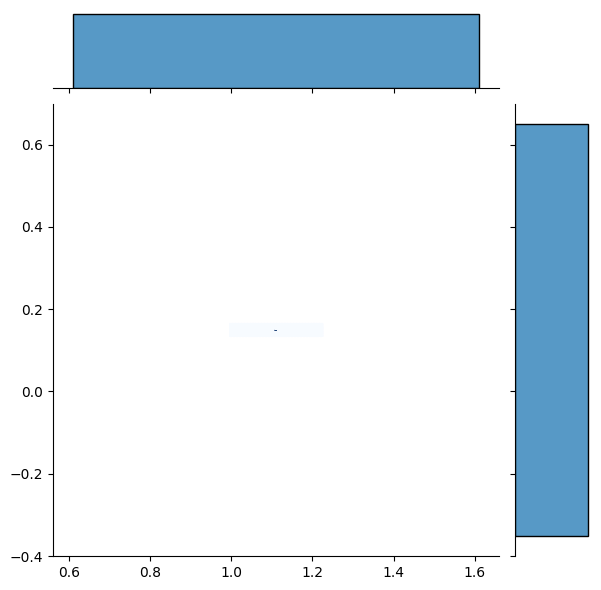

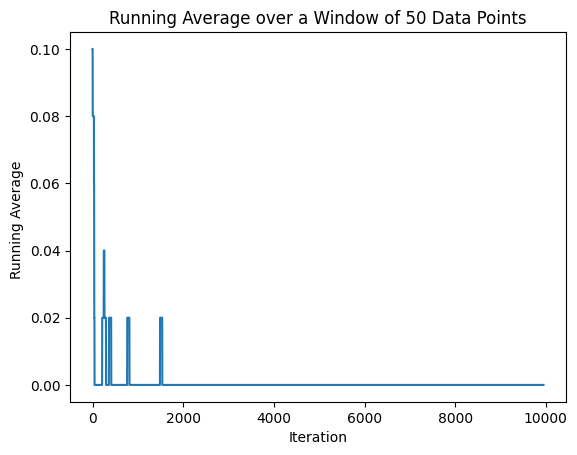

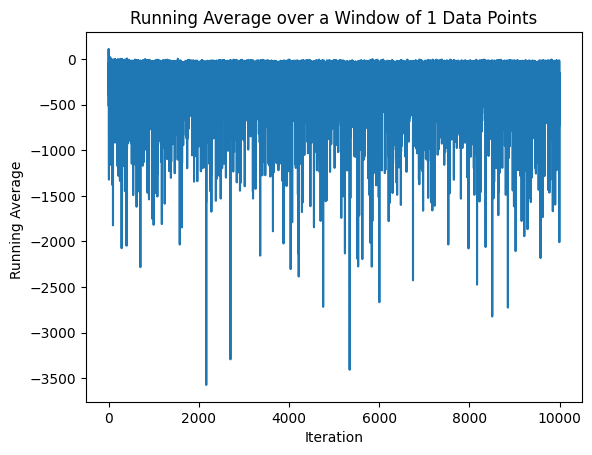

In [21]:
print(np.median(lkhd))
print(np.median(correction_term))
print(np.median(acceptence_prob))

plot_samples = create_sample(samples, 5000,5)
print(sample_quality_score(plot_samples, np.array([0,8])))

plt_samples(plot_samples)

plot_running_average(accepted,50)

plot_running_average(lkhd_diff, 1)

## FireflyMC

In [22]:
def firefly_sampler(data, theta, lkhd_function, standard_subsampling_perc, ):
    z = bernoulli_sampling(data, standard_subsampling_perc)
    adaptive_subsampling_perc = 1 - lkhd_function.comp_func/ lkhd_function.comp_bounding_func

    sample = bernoulli_sampling(z, adaptive_subsampling_perc)
    return sample, adaptive_subsampling_perc

def comp_firefly_joint_prob(data, subsample, theta, lkhd_function, lkhd_MAP, grad_MAP, hess_MAP):
    bounding_part = lkhd_function.comp_log_bound_func(data, theta, lkhd_MAP, grad_MAP, hess_MAP)
    logB = lkhd_function.comp_log_bound_func(subsample, theta, lkhd_MAP, grad_MAP, hess_MAP)
    logL = lkhd_function.comp_func(subsample, theta)
    adaptive_part = np.log(np.exp(logL)/np.exp(logB) - 1)
    joint_prob = bounding_part + adaptive_part
    joint_prob = np.exp(joint_prob)
    return joint_prob


In [23]:
def firefly_sampling(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, subsampling_perc, thetaMAP):
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    samples[0] = initial_theta
    adaptive_sampling_perc = np.empty(num_iterations)
    adaptive_sampling_perc[0] = subsampling_perc
    #Initialize variables for bounding function
    lkhd_MAP = np.mean(lkhd_function.comp_func(data, thetaMAP))
    grad_MAP = lkhd_function.comp_grad(data, thetaMAP)
    hess_MAP = lkhd_function.comp_hess(data, thetaMAP)

    for i in range(num_iterations - 1):
        # Propose a new sample
        current = samples[i]
        subsample, adaptive_sampling_perc[i] = firefly_sampler(data, current, lkhd_function,subsampling_perc)
        proposal = proposal_function.propose_sample(current, stepsize)

        # Compute the acceptance probability
        joint_prob_curr = comp_firefly_joint_prob(subsample, current, lkhd_function, lkhd_MAP, grad_MAP, hess_MAP)
        joint_prob_prop = comp_firefly_joint_prob(subsample, proposal, lkhd_function, lkhd_MAP, grad_MAP, hess_MAP)
        acceptence_prob[i] = joint_prob_prop/joint_prob_curr

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd
